# EDA & Cleaning

In [2]:
#IMPORTS
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (10, 2)

In [3]:
#LOAD LOANSTATS
directory = '../../data/'
ls = pd.read_hdf(directory + 'Ls_MERGED.h5', 'ls_MERGED') # HDF5
ls.sort_index(axis=1, inplace=True)

In [4]:
#LOAD DATA DICTIONARY
sheet_dict = pd.read_excel(directory + 'LCDataDictionary.xlsx', sheet_name=None)
data_dict = {}
for key in sheet_dict:
    for index, row in sheet_dict[key].iterrows():
        if type(row[0]) != float:
            data_dict[row[0].strip()] = row[1]

In [5]:
#FUNCTION FOR DUMMY CREATION
def dummy_attr(attr):
    """ Create dummmies and drop original attribute"""
    global ls
    if attr not in list(ls): return
    prefix = 'D_' + attr
    dummies = pd.get_dummies(ls[attr], prefix=prefix)
    ls.drop([attr], axis=1, inplace=True)
    ls = pd.concat([ls, dummies], axis=1)

In [6]:
#FUNCTION FOR OUTLIER DETECTION
ls['outlier'] = 0 # this column is incremented for identified outlier instances
def outlier_attr(attr, threshold):
    """ Identify outliers above threshold""" 
    outliers = ls[attr] > threshold
    ls['outlier'] = ls['outlier'] + outliers
    return outliers

In [7]:
#FUNCTION FOR MISSING VALUE IMPUTATION
from sklearn.impute import SimpleImputer

def impute_attr(attr, strategy='median'):
    """ Impute missing values (via mean imputation or constant imputation)"""
    mnths_since = ls.columns[ls.columns.str.contains('mo_sin|mths_since')]
    if attr in mnths_since:
        imp = SimpleImputer(strategy='constant', fill_value=0)
    elif ls[attr].min() == 0:                                
        imp = SimpleImputer(strategy='constant', fill_value=0)
    else:
        imp = SimpleImputer(strategy='mean')
    ls[attr] = imp.fit_transform(ls[[attr]])

In [8]:
#FUNCTION FOR EDA
def EDA_attr(attr):
    """ Display basic EDA for given attribute"""
    mnths_since = ls.columns[ls.columns.str.contains('mo_sin|mths_since')]
    display(Markdown('**{}**: {}'.format(attr, data_dict.get(attr, ""))))
    
    #attribute type
    attr_type = ls[attr].dtype
    print('\tType: \t\t\t{}'.format(attr_type))
    
    #missing values
    missing_values = ls[attr].isnull().sum()
    num_observations = len(ls)
    print('\tMissing Values: \t{} ({:.1%})'.format(missing_values, missing_values/num_observations), end='')
    if missing_values > 0:
        if (ls[attr].min() == 0) or (attr in mnths_since):
            print(' <-- Zero Imputation Applied', end='')
        else:
            print(' <-- Mean Imputation Applied', end='')
    print()
    
    #numerical variables
    if attr_type == 'float64' or attr_type == 'int64':  
        impute_attr(attr)  
        print('\tMean: \t\t\t{:.2f}'.format(ls[attr].mean()))     
        print('\tRange: \t\t\t({:.2f}, {:.2f})'.format(ls[attr].min(), ls[attr].max()))
        plt.hist(ls[attr]); plt.ylabel('Number of Loans'); plt.xlabel(attr); plt.show()
  
    #categorical variables
    if attr_type == 'object':   
        print('\tNumber of Dummies: \t{}'.format(len(ls.groupby(attr))))
        print('\tMost Common Category: \t{}'.format(ls.groupby(attr)['loan_amnt'].count().idxmax()))
        dummy_attr(attr)

    display(Markdown('\n'))

## 1. Term-Complete Representative Subset

'Term-complete' loans have completed their full term whereas 'in-force' loans have not completed their term.  To get the most representative outcome information we first remove the loan instances that are not term-complete. Also, LC no longer offers loans of of the lowest grades of F or G, so we remove these loans from the dataset.

In [9]:
#TERM-COMPLETE GRADES A-E
completed_36 = (ls['issue_d'] < '2015-04-01') & (ls['term']  == ' 36 months')
completed_60 = (ls['issue_d'] < '2013-04-01') & (ls['term']  == ' 60 months')
ls = ls[completed_36 | completed_60]
ls = ls[(ls['grade'] != 'F') & (ls['grade'] != 'G')]

## 2. Inconsequential Variable Removal

We removed variables from the `loanstats` dataset that would not be meaningful in the modeling for the following reasons:
1. LC recently began reporting some new variables which are not reported in the term-complete subset. 
2. LC recently began accepting joint loans and variables related to coborrowers are empty in the term-complete subset. 
3. We designed three outcome features based on the set of dependent variables (see next section)
4. Some variables are non-standard text descriptions or otherwise inconsequential

In [10]:
#1 NEW
empty = ['all_util', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 
         'mths_since_rcnt_il', 'open_acc_6m', 'open_act_il', 'open_il_12m', 
         'open_il_24m', 'open_rv_12m', 'open_rv_24m','total_bal_il', 'total_cu_tl']

#2 CO-BORROWER
joint = ['application_type', 'annual_inc_joint', 'dti_joint', 'revol_bal_joint', 
         'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 
         'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 
         'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 
         'sec_app_open_act_il', 'sec_app_revol_util', 'verification_status_joint']

#3 DEPENDENT
dependent = [# Payment Variables (11): 
              'issue_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_status', 
              'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
              'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp', 
             # Hardship/Collections/Settlements (27)
              'collection_recovery_fee', 'debt_settlement_flag', 'debt_settlement_flag_date', 
              'deferral_term', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 
              'hardship_flag', 'hardship_last_payment_amount','hardship_length', 'hardship_loan_status', 
              'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 
              'hardship_status', 'hardship_type', 'last_credit_pull_d', 
              'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'pymnt_plan', 
              'recoveries', 'settlement_amount', 'settlement_date', 'settlement_percentage', 
              'settlement_status', 'settlement_term', 'total_rec_late_fee']

#4 OTHER INCONSEQUENTIAL
inconsequential = ['addr_state', # not useful as dummy variable
                   'dataset', # just indicates the dataset
                   'desc', # non-standard text description
                   'disbursement_method', # just indicates cash or direct_pay
                   'emp_title', # non-standard text description
                   'funded_amnt', # redundant with loan_amount
                   'funded_amnt_inv', # redundant with loan_amount
                   'grade', # redundant when using sub_grade
                   'initial_list_status', # possible values are w or f
                   'title', # non-standard text description
                   'zip_code'] # we could make into dummies, but there are 954 of them

In [11]:
ls.drop(empty, axis=1, inplace=True)
ls.drop(joint, axis=1, inplace=True)
ls.drop(inconsequential, axis=1, inplace=True)

## 3. Outcome Feature Design

We designed 3 outcome features to represent how well or poorly the loan performed: `OUT_Class`, `OUT_Principle_Repaid_Percentage` and `OUT_Monthly_Rate_of_Return`.

### 3A. `OUT_Class`

This outcome variable is a binary classification of whether the loan has been Fully Repaid (1) or Not Fully Repaid (0). The percentage of loans that have been fully repaid is 85.9%.

In [12]:
ls['OUT_Class'] = 0
ls.loc[ls['loan_status'].str.contains('Fully Paid'), 'OUT_Class'] = 1

In [13]:
ls.loc[ls['loan_status'].str.contains('Current'), 'OUT_Class'] = 1

### 3B. `OUT_Principle_Repaid_Percentage`

This outcome variable represents the percentage of loan principle that has been repaid. The average principal repaid percentage is 91.5%.

In [14]:
ls['OUT_Principle_Repaid_Percentage'] = ls['total_rec_prncp'] / ls['loan_amnt']

### 3C. `OUT_Monthly_Rate_of_Return`

This outcome variable represents the simple monthly rate of return that investors recieved by holding the loan. This is the most comprehensive of the three outcome features because it takes into account the total amount repaid (including interest) for the effective term of the loan. The median monthly rate of return is 0.6%.

In [15]:
#NET_REPAYMENT: amount repaid on the loan net of the loan amount
Net_Repayment = ls['total_pymnt'] - ls['loan_amnt']

#REPAYMENT_PERIOD: amount of time it took to repay the loan or charge off
Repayment_Period = (ls['last_pymnt_d'].dt.to_period('M') - 
                    ls['issue_d'].dt.to_period('M')).replace([pd.NaT,0], 1)

#MONTHLY_RATE_OF_RETURN: simple monthly return accrued over the term of the loan
ls['OUT_Monthly_Rate_Of_Return'] = (Net_Repayment / Repayment_Period) / ls['loan_amnt']

## 4. Independent Feature Cleaning

We cleaned each independent variable with type conversion, dummy creation and outlier identification. Loans that had missing values in more than half of the independent variables were dropped while the remaining missing values were imputed with mean imputation or zero imputation. See the appendix for the custom functions that we employed.

In [16]:
#EARLIEST_CR_LINE
ls['earliest_cr_line'] =  np.array((ls['issue_d'] - 
                                    ls['earliest_cr_line']).dt.days).reshape(-1,1)

#EMP_LENGTH
mapping = {'1 year': 1, '10+ years': 10, '2 years': 2, '3 years': 3, 
           '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, 
           '8 years': 8, '9 years': 9, '< 1 year': 0}
ls['emp_length'] = ls['emp_length'].map(mapping)

#HOME_OWNERSHIP
ls['home_ownership'].replace({'ANY':'OTHER', 'NONE':'OTHER'}, inplace=True)

#INT_RATE
ls['int_rate'] = ls['int_rate'].str[:-1].astype(np.float)

#REVOL_UTIL
ls['revol_util'] = ls['revol_util'].str[:-1].astype(np.float)

#SUB_GRADE
mapping = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}
ls['sub_grade'] = (ls['sub_grade'].apply(lambda x: x[0]).map(mapping).astype(int)*5 +
                         ls['sub_grade'].apply(lambda x: x[1]).astype(int)).astype(float)

#'MTHS_SINCE...' reciprocals
#use reciprocal so that 0='never occured' and 1/n+1='n month since'
mnths_since = ls.columns[ls.columns.str.contains('mo_sin|mths_since')]
for var in mnths_since:
    ls[var+'_R'] = 1 / (ls[var] + 1)
ls.drop(mnths_since, axis=1, inplace=True)

In [17]:
ls.drop(dependent, axis=1, inplace=True)
ls = ls[ls.isnull().sum(axis=1) < 30]

## 5. EDA

### 5A. Outcome Features

**OUT_Class**: Binary classification of whether the loan has been Fully Repaid (1) or Not Fully Repaid (0)

	Type: 			int64
	Missing Values: 	0 (0.0%)
	Mean: 			0.86
	Range: 			(0.00, 1.00)


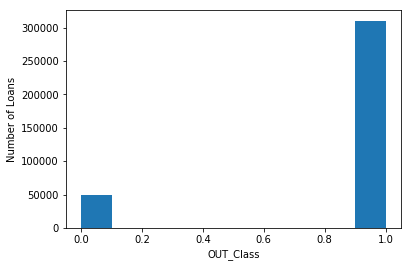

**OUT_Monthly_Rate_Of_Return**: Simple monthly rate of return that investors recieved by holding the loan

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			-0.00
	Range: 			(-1.00, 0.21)


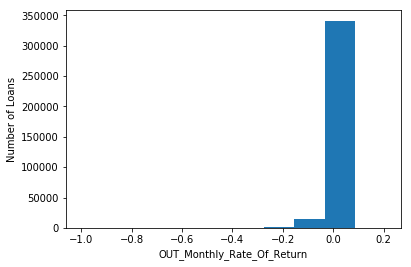

**OUT_Principle_Repaid_Percentage**: Percentage of loan principle that has been repaid

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.92
	Range: 			(0.00, 1.00)


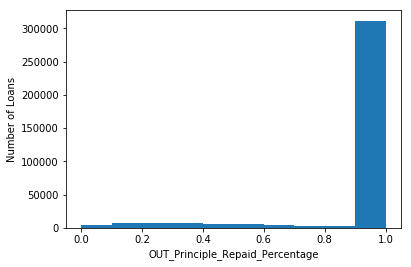

In [18]:
outcome_cols = [attr for attr in ls.columns if 'OUT_' in attr]
for attr in sorted(outcome_cols):
    EDA_attr(attr)

### 5B. Dummy Variables

In [19]:
dummy_cols = [attr for attr in ls.columns if ls[attr].dtype == 'object']
for attr in sorted(dummy_cols):
    EDA_attr(attr)

**home_ownership**: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Dummies: 	4
	Most Common Category: 	MORTGAGE


**purpose**: A category provided by the borrower for the loan request. 

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Dummies: 	13
	Most Common Category: 	debt_consolidation


**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Dummies: 	2
	Most Common Category: 	 36 months


**verification_status**: Indicates if income was verified by LC, not verified, or if the income source was verified

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Dummies: 	3
	Most Common Category: 	Not Verified


### 5C. Numeric Variables

**acc_now_delinq**: The number of accounts on which the borrower is now delinquent.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.00
	Range: 			(0.00, 14.00)


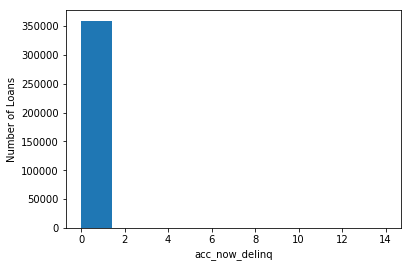

**acc_open_past_24mths**: Number of trades opened in past 24 months.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			4.19
	Range: 			(0.00, 53.00)


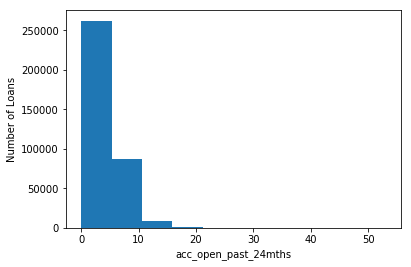

**annual_inc**: The self-reported annual income provided by the borrower during registration.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			72099.75
	Range: 			(3000.00, 8706582.00)


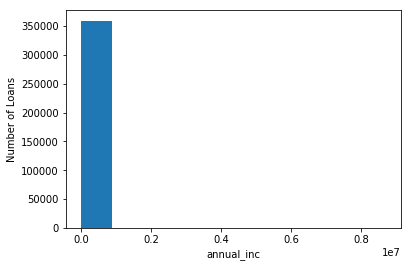

**avg_cur_bal**: Average current balance of all accounts

	Type: 			float64
	Missing Values: 	13856 (3.9%) <-- Zero Imputation Applied
	Mean: 			12232.31
	Range: 			(0.00, 958084.00)


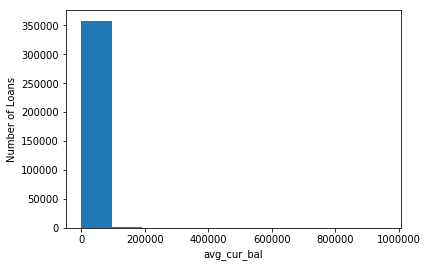

**bc_open_to_buy**: Total open to buy on revolving bankcards.

	Type: 			float64
	Missing Values: 	3349 (0.9%) <-- Zero Imputation Applied
	Mean: 			8455.84
	Range: 			(0.00, 497445.00)


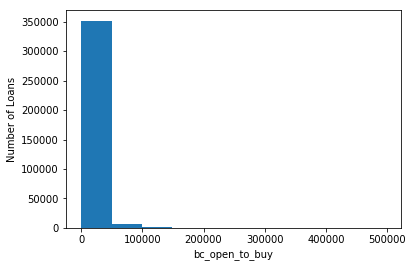

**bc_util**: Ratio of total current balance to high credit/credit limit for all bankcard accounts.

	Type: 			float64
	Missing Values: 	3579 (1.0%) <-- Zero Imputation Applied
	Mean: 			63.65
	Range: 			(0.00, 339.60)


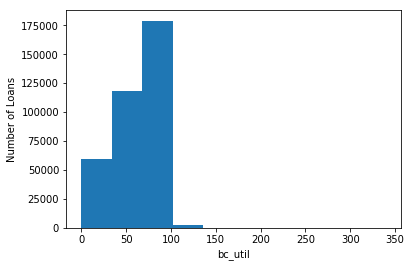

**chargeoff_within_12_mths**: Number of charge-offs within 12 months

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.01
	Range: 			(0.00, 7.00)


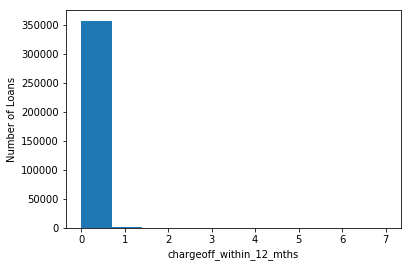

**collections_12_mths_ex_med**: Number of collections in 12 months excluding medical collections

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.01
	Range: 			(0.00, 20.00)


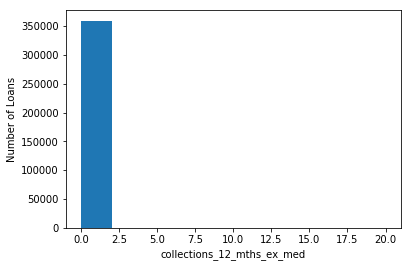

**delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.31
	Range: 			(0.00, 29.00)


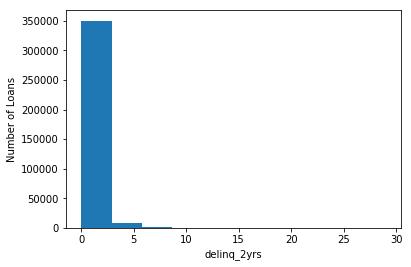

**delinq_amnt**: The past-due amount owed for the accounts on which the borrower is now delinquent.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			10.13
	Range: 			(0.00, 86399.00)


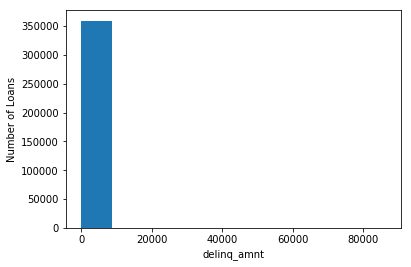

**dti**: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			17.49
	Range: 			(0.00, 39.99)


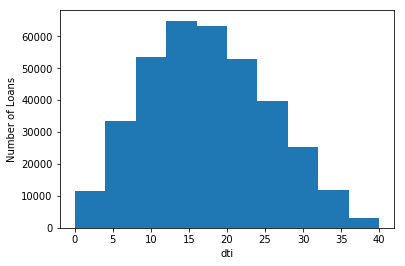

**earliest_cr_line**: The month the borrower's earliest reported credit line was opened

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			5871.88
	Range: 			(1096.00, 25933.00)


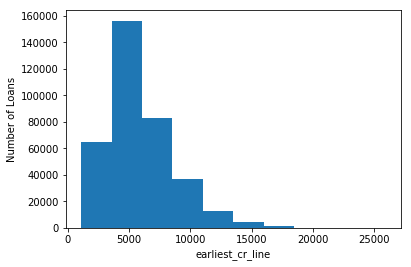

**emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

	Type: 			float64
	Missing Values: 	19535 (5.4%) <-- Zero Imputation Applied
	Mean: 			5.64
	Range: 			(0.00, 10.00)


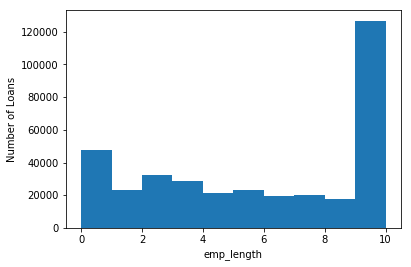

**inq_last_6mths**: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.74
	Range: 			(0.00, 8.00)


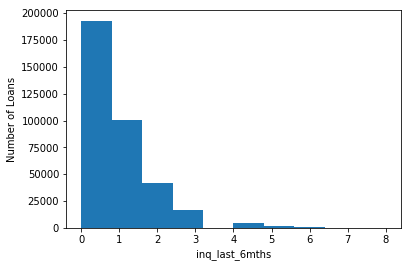

**installment**: The monthly payment owed by the borrower if the loan originates.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			423.83
	Range: 			(14.01, 1362.15)


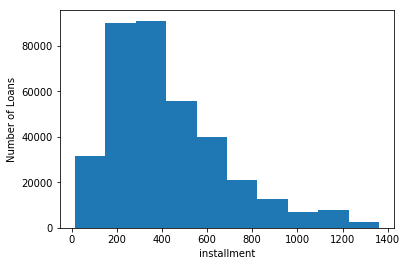

**int_rate**: Interest Rate on the loan

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			12.67
	Range: 			(5.93, 23.40)


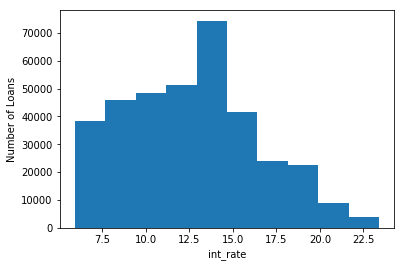

**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			12855.10
	Range: 			(1000.00, 35000.00)


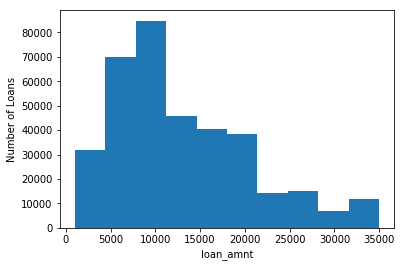

**mo_sin_old_il_acct_R**: Reciprocal of the number of months since oldest bank installment account opened

	Type: 			float64
	Missing Values: 	27076 (7.5%) <-- Zero Imputation Applied
	Mean: 			0.01
	Range: 			(0.00, 1.00)


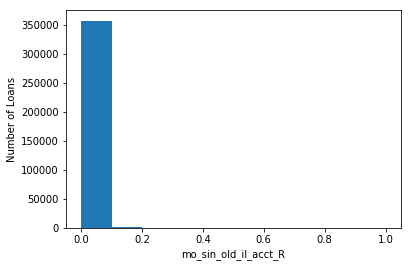

**mo_sin_old_rev_tl_op_R**: Reciprocal of the number of months since oldest revolving account opened

	Type: 			float64
	Missing Values: 	13848 (3.9%) <-- Zero Imputation Applied
	Mean: 			0.01
	Range: 			(0.00, 0.25)


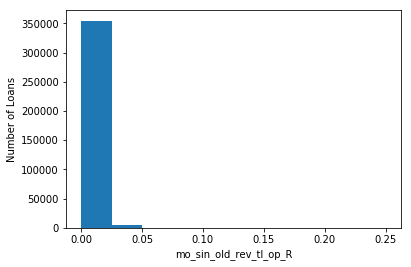

**mo_sin_rcnt_rev_tl_op_R**: Reciprocal of the number of months since most recent revolving account opened

	Type: 			float64
	Missing Values: 	13848 (3.9%) <-- Zero Imputation Applied
	Mean: 			0.16
	Range: 			(0.00, 1.00)


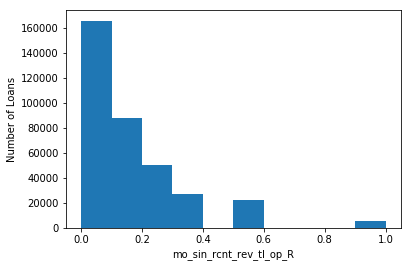

**mo_sin_rcnt_tl_R**: Reciprocal of the number of months since most recent account opened

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			0.19
	Range: 			(0.00, 1.00)


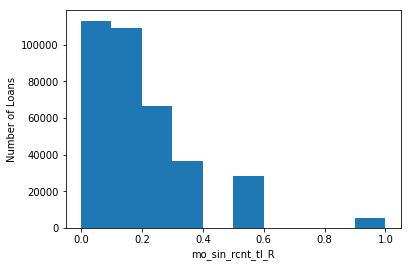

**mort_acc**: Number of mortgage accounts.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			1.70
	Range: 			(0.00, 34.00)


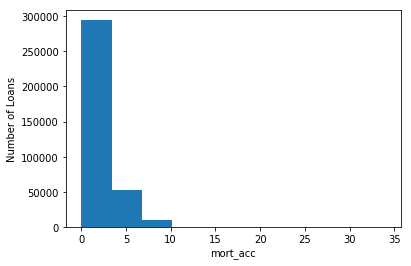

**mths_since_last_delinq_R**: Reciprocal of the number of months since the borrower's last delinquency.

	Type: 			float64
	Missing Values: 	184496 (51.3%) <-- Zero Imputation Applied
	Mean: 			0.03
	Range: 			(0.00, 1.00)


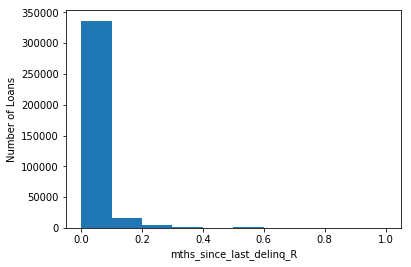

**mths_since_last_major_derog_R**: Reciprocal of the number of months since most recent 90-day or worse rating

	Type: 			float64
	Missing Values: 	269413 (75.0%) <-- Zero Imputation Applied
	Mean: 			0.01
	Range: 			(0.00, 1.00)


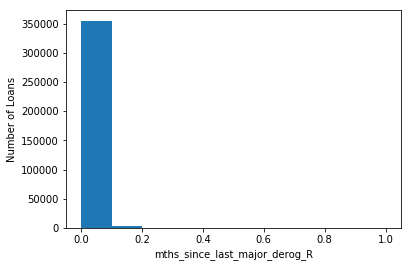

**mths_since_last_record_R**: Reciprocal of the number of months since the last public record.

	Type: 			float64
	Missing Values: 	304602 (84.8%) <-- Zero Imputation Applied
	Mean: 			0.00
	Range: 			(0.00, 1.00)


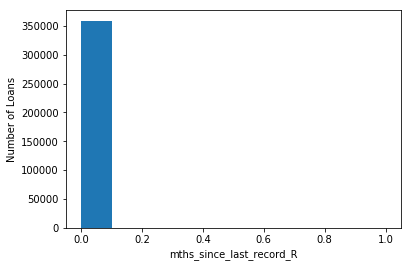

**mths_since_recent_bc_R**: Reciprocal of the number of months since most recent bankcard account opened.

	Type: 			float64
	Missing Values: 	3026 (0.8%) <-- Zero Imputation Applied
	Mean: 			0.11
	Range: 			(0.00, 1.00)


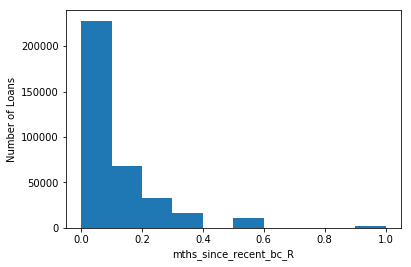

**mths_since_recent_bc_dlq_R**: Reciprocal of the number of months since most recent bankcard delinquency

	Type: 			float64
	Missing Values: 	271846 (75.6%) <-- Zero Imputation Applied
	Mean: 			0.01
	Range: 			(0.00, 1.00)


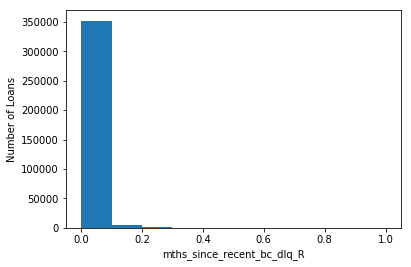

**mths_since_recent_inq_R**: Reciprocal of the number of months since most recent inquiry.

	Type: 			float64
	Missing Values: 	37435 (10.4%) <-- Zero Imputation Applied
	Mean: 			0.23
	Range: 			(0.00, 1.00)


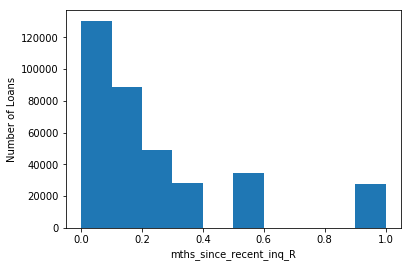

**mths_since_recent_revol_delinq_R**: Reciprocal of the number of months since most recent revolving delinquency.

	Type: 			float64
	Missing Values: 	235793 (65.6%) <-- Zero Imputation Applied
	Mean: 			0.02
	Range: 			(0.00, 1.00)


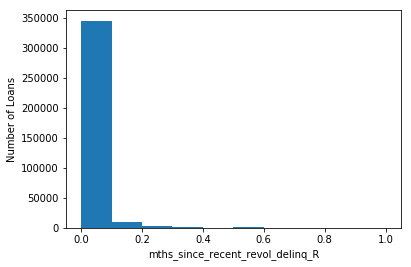

**num_accts_ever_120_pd**: Number of accounts ever 120 or more days past due

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			0.44
	Range: 			(0.00, 35.00)


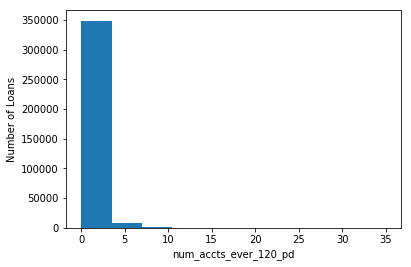

**num_actv_bc_tl**: Number of currently active bankcard accounts

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			3.52
	Range: 			(0.00, 30.00)


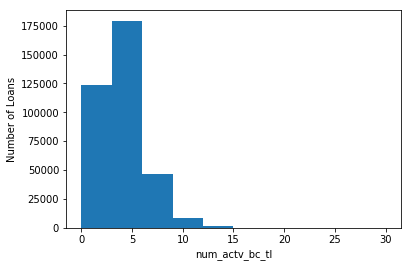

**num_actv_rev_tl**: Number of currently active revolving trades

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			5.45
	Range: 			(0.00, 41.00)


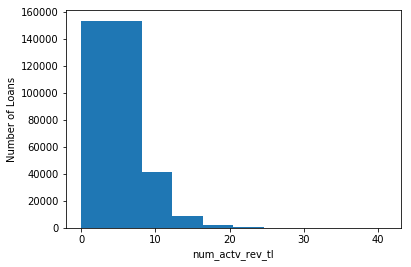

**num_bc_sats**: Number of satisfactory bankcard accounts

	Type: 			float64
	Missing Values: 	2698 (0.8%) <-- Zero Imputation Applied
	Mean: 			4.58
	Range: 			(0.00, 46.00)


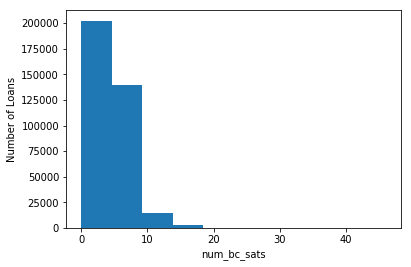

**num_bc_tl**: Number of bankcard accounts

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			8.28
	Range: 			(0.00, 65.00)


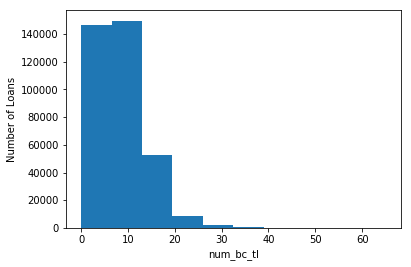

**num_il_tl**: Number of installment accounts

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			7.68
	Range: 			(0.00, 150.00)


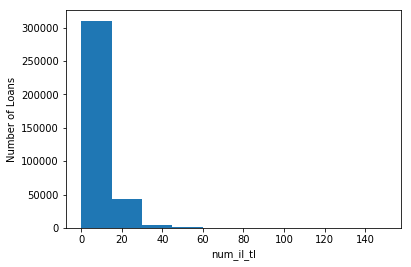

**num_op_rev_tl**: Number of open revolving accounts

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			7.80
	Range: 			(0.00, 62.00)


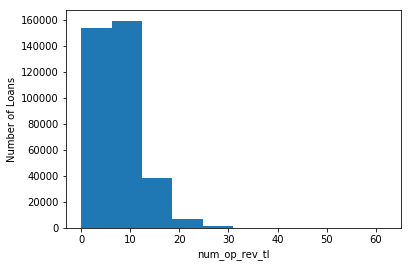

**num_rev_accts**: Number of revolving accounts

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			14.37
	Range: 			(0.00, 105.00)


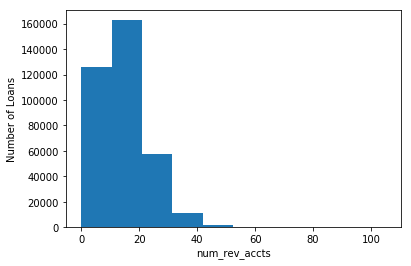

**num_rev_tl_bal_gt_0**: Number of revolving trades with balance >0

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			5.43
	Range: 			(0.00, 38.00)


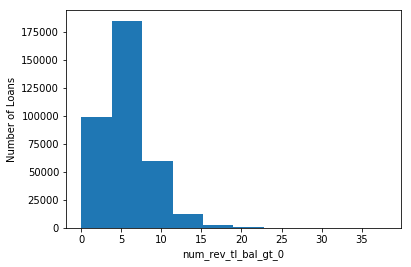

**num_sats**: Number of satisfactory accounts

	Type: 			float64
	Missing Values: 	2698 (0.8%) <-- Zero Imputation Applied
	Mean: 			11.14
	Range: 			(0.00, 84.00)


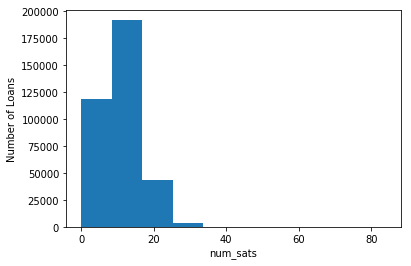

**num_tl_120dpd_2m**: Number of accounts currently 120 days past due (updated in past 2 months)

	Type: 			float64
	Missing Values: 	22258 (6.2%) <-- Zero Imputation Applied
	Mean: 			0.00
	Range: 			(0.00, 3.00)


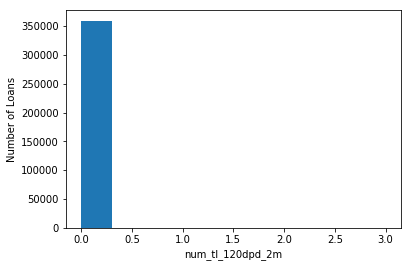

**num_tl_30dpd**: Number of accounts currently 30 days past due (updated in past 2 months)

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			0.00
	Range: 			(0.00, 4.00)


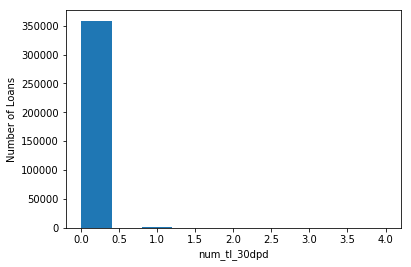

**num_tl_90g_dpd_24m**: Number of accounts 90 or more days past due in last 24 months

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			0.08
	Range: 			(0.00, 24.00)


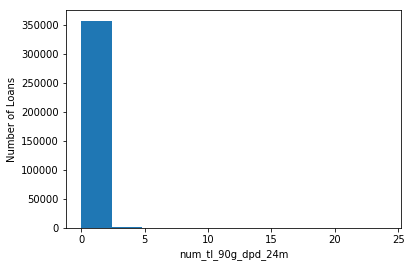

**num_tl_op_past_12m**: Number of accounts opened in past 12 months

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			1.86
	Range: 			(0.00, 26.00)


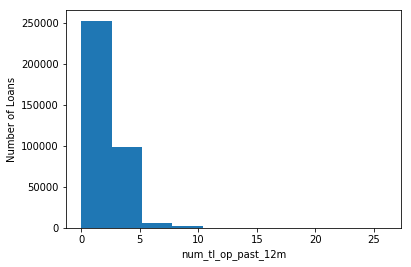

**open_acc**: The number of open credit lines in the borrower's credit file.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			11.26
	Range: 			(0.00, 84.00)


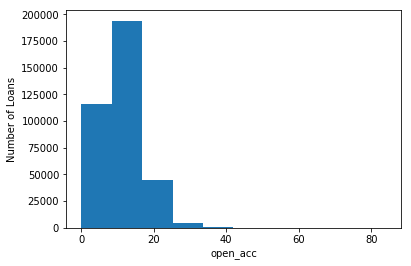

**outlier**: 

	Type: 			int64
	Missing Values: 	0 (0.0%)
	Mean: 			0.00
	Range: 			(0.00, 0.00)


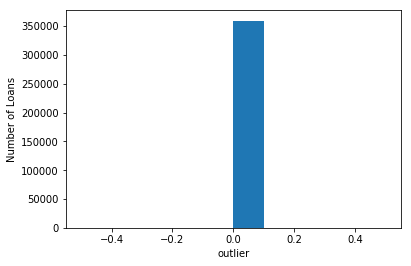

**pct_tl_nvr_dlq**: Percent of trades never delinquent

	Type: 			float64
	Missing Values: 	13961 (3.9%) <-- Mean Imputation Applied
	Mean: 			94.45
	Range: 			(7.70, 100.00)


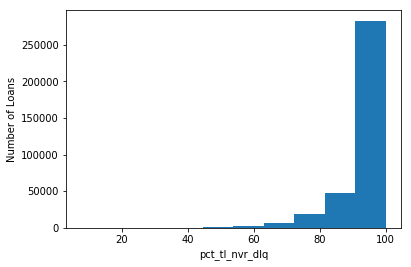

**percent_bc_gt_75**: Percentage of all bankcard accounts > 75% of limit.

	Type: 			float64
	Missing Values: 	3473 (1.0%) <-- Zero Imputation Applied
	Mean: 			49.84
	Range: 			(0.00, 100.00)


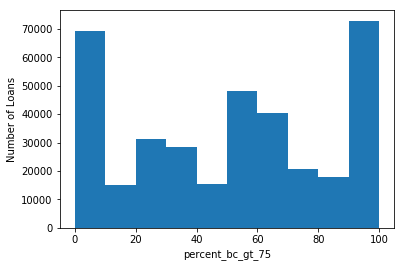

**pub_rec**: Number of derogatory public records

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.19
	Range: 			(0.00, 63.00)


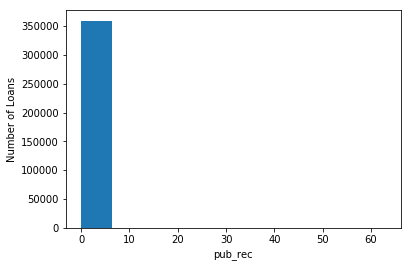

**pub_rec_bankruptcies**: Number of public record bankruptcies

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.12
	Range: 			(0.00, 12.00)


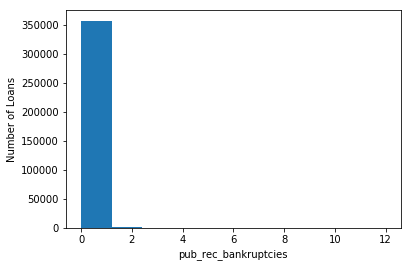

**revol_bal**: Total credit revolving balance

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			15574.30
	Range: 			(0.00, 2568995.00)


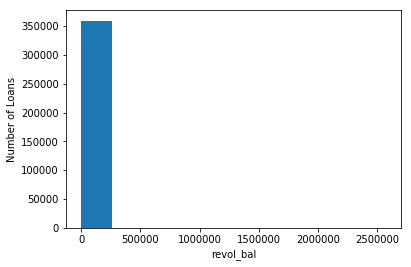

**revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

	Type: 			float64
	Missing Values: 	170 (0.0%) <-- Zero Imputation Applied
	Mean: 			55.49
	Range: 			(0.00, 892.30)


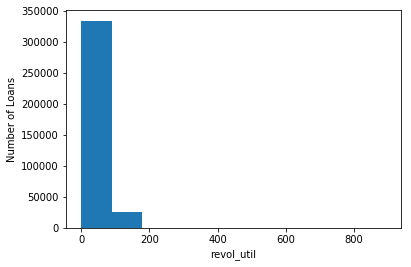

**sub_grade**: LC assigned loan subgrade

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			10.30
	Range: 			(1.00, 25.00)


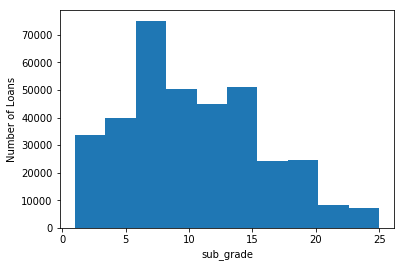

**tax_liens**: Number of tax liens

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			0.04
	Range: 			(0.00, 63.00)


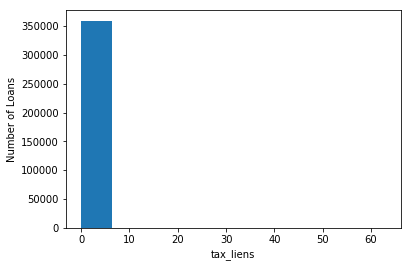

**tot_coll_amt**: Total collection amounts ever owed

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			205.47
	Range: 			(0.00, 9152545.00)


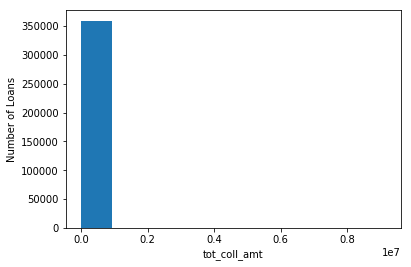

**tot_cur_bal**: Total current balance of all accounts

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			123952.77
	Range: 			(0.00, 8000078.00)


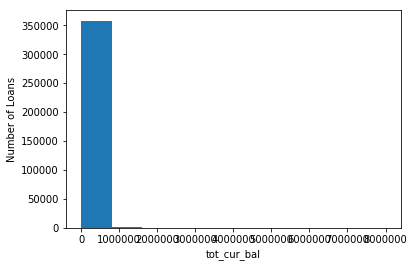

**tot_hi_cred_lim**: Total high credit/credit limit

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			151986.14
	Range: 			(0.00, 9999999.00)


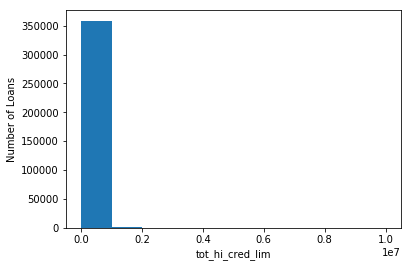

**total_acc**: The total number of credit lines currently in the borrower's credit file

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			24.90
	Range: 			(2.00, 162.00)


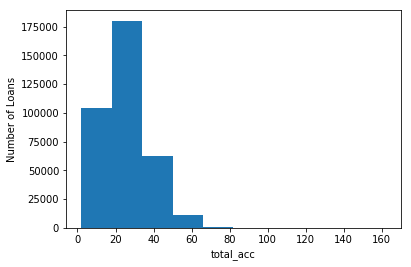

**total_bal_ex_mort**: Total credit balance excluding mortgage

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			44161.05
	Range: 			(0.00, 2688920.00)


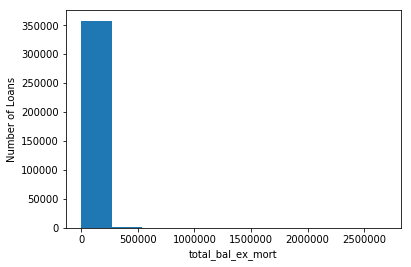

**total_bc_limit**: Total bankcard high credit/credit limit

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			19654.58
	Range: 			(0.00, 760000.00)


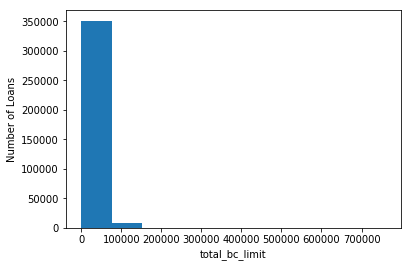

**total_il_high_credit_limit**: Total installment high credit/credit limit

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			34931.70
	Range: 			(0.00, 1241783.00)


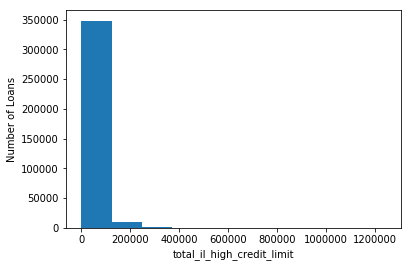

**total_rev_hi_lim**: Total revolving high credit/credit limit

	Type: 			float64
	Missing Values: 	13847 (3.9%) <-- Zero Imputation Applied
	Mean: 			28445.27
	Range: 			(0.00, 9999999.00)


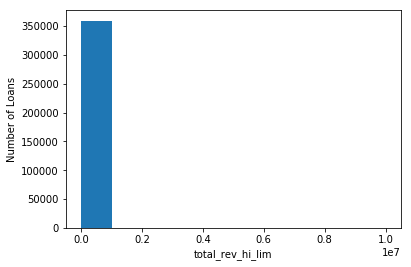

In [20]:
dummies = ls.columns[ls.columns.str.contains('D_')]
numeric_cols = set(ls.columns) - set(dummies) - set(outcome_cols)
for attr in sorted(numeric_cols):
    EDA_attr(attr)

In [21]:
############ EXPORTING ##############
ls.drop('outlier', axis=1, inplace=True)
ls.to_hdf(directory + 'ls_CLEAN.h5', 'ls_CLEAN')

## Appendix: Custom Functions

In [22]:
#FUNCTION FOR DUMMY CREATION
def dummy_attr(attr):
    """ Create dummmies and drop original attribute"""
    global ls
    if attr not in list(ls): return
    prefix = 'D_' + attr
    dummies = pd.get_dummies(ls[attr], prefix=prefix)
    ls.drop([attr], axis=1, inplace=True)
    ls = pd.concat([ls, dummies], axis=1)

In [23]:
#FUNCTION FOR OUTLIER DETECTION
ls['outlier'] = 0 # this column is incremented for identified outlier instances
def outlier_attr(attr, threshold):
    """ Identify outliers above threshold""" 
    outliers = ls[attr] > threshold
    ls['outlier'] = ls['outlier'] + outliers
    return outliers

In [24]:
#FUNCTION FOR MISSING VALUE IMPUTATION
from sklearn.impute import SimpleImputer
mnths_since = ['mths_since_last_delinq_R', 'mths_since_last_major_derog_R',
               'mths_since_last_record_R', 'mths_since_recent_bc_dlq_R',
               'mths_since_recent_inq_R', 'mths_since_recent_revol_delinq_R']
def impute_attr(attr, strategy='median'):
    """ Impute missing values (via mean imputation or constant imputation)"""
    if attr in mnths_since:
        imp = SimpleImputer(strategy='constant', fill_value=0)
    elif ls[attr].min() == 0:                                
        imp = SimpleImputer(strategy='constant', fill_value=0)
    else:
        imp = SimpleImputer(strategy='mean')
    ls[attr] = imp.fit_transform(ls[[attr]])

In [25]:
#FUNCTION FOR EDA
def EDA_attr(attr):
    """ Display basic EDA for given attribute"""
    display(Markdown('**{}**: {}'.format(attr, data_dict.get(attr, ""))))
    
    #attribute type
    attr_type = ls[attr].dtype
    print('\tType: \t\t\t{}'.format(attr_type))
    
    #missing values
    missing_values = ls[attr].isnull().sum()
    num_observations = len(ls)
    print('\tMissing Values: \t{} ({:.1%})'.format(missing_values, missing_values/num_observations), end='')
    if missing_values > 0:
        if (ls[attr].min() == 0) or (attr in mnths_since):
            print(' <-- Zero Imputation Applied', end='')
        else:
            print(' <-- Mean Imputation Applied', end='')
    print()
    
    #numerical variables
    if attr_type == 'float64' or attr_type == 'int64':  
        impute_attr(attr)  
        print('\tMean: \t\t\t{:.2f}'.format(ls[attr].mean()))     
        print('\tRange: \t\t\t({:.2f}, {:.2f})'.format(ls[attr].min(), ls[attr].max()))
        plt.hist(ls[attr]); plt.ylabel('Number of Loans'); plt.xlabel(attr); plt.show()
  
    #categorical variables
    if attr_type == 'object':   
        print('\tNumber of Dummies: \t{}'.format(len(ls.groupby(attr))))
        print('\tMost Common Category: \t{}'.format(ls.groupby(attr)['loan_amnt'].count().idxmax()))
        dummy_attr(attr)

    display(Markdown('\n'))